<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/sequence_prediction%20(LSTM%20per%20seq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
MODEL_NAME = 'LSTM'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = LSTM, DEVICE = cuda


# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [4]:
#Y = np.array([(np.sin(x), np.cos(x)) for x in X])
Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
Y[:10]

array([[0.04679531, 1.10449275],
       [0.13999053, 0.91638862],
       [0.30445672, 1.19547418],
       [0.52777801, 1.09457161],
       [0.5436313 , 0.81275558],
       [0.45770548, 0.88217079],
       [0.72498917, 0.89228431],
       [0.75317312, 0.71914153],
       [0.75907292, 0.66197398],
       [0.86718584, 0.54961085]])

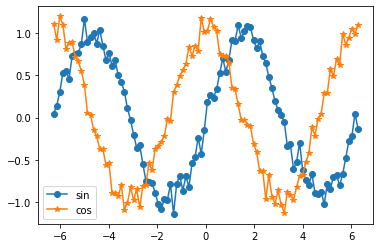

In [5]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

# Convert numpy array to torch.Tensor

In [6]:
# convert Y into input tensors
#input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
input_tensor.shape

torch.Size([100, 2])

In [7]:
# check input_tensor
input_tensor[:10]

tensor([[0.0468, 1.1045],
        [0.1400, 0.9164],
        [0.3045, 1.1955],
        [0.5278, 1.0946],
        [0.5436, 0.8128],
        [0.4577, 0.8822],
        [0.7250, 0.8923],
        [0.7532, 0.7191],
        [0.7591, 0.6620],
        [0.8672, 0.5496]], device='cuda:0')

In [8]:
# make target_tensor by rotating input_tensor
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
#target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1400, 0.9164],
        [0.3045, 1.1955],
        [0.5278, 1.0946],
        [0.5436, 0.8128],
        [0.4577, 0.8822],
        [0.7250, 0.8923],
        [0.7532, 0.7191],
        [0.7591, 0.6620],
        [0.8672, 0.5496],
        [1.1632, 0.3865]], device='cuda:0')

In [9]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[0.0468, 1.1045, 0.1400, 0.9164],
        [0.1400, 0.9164, 0.3045, 1.1955],
        [0.3045, 1.1955, 0.5278, 1.0946],
        [0.5278, 1.0946, 0.5436, 0.8128],
        [0.5436, 0.8128, 0.4577, 0.8822],
        [0.4577, 0.8822, 0.7250, 0.8923],
        [0.7250, 0.8923, 0.7532, 0.7191],
        [0.7532, 0.7191, 0.7591, 0.6620],
        [0.7591, 0.6620, 0.8672, 0.5496],
        [0.8672, 0.5496, 1.1632, 0.3865]], device='cuda:0')


# Create RNN Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size).to(DEVICE)
        self.h2o = nn.Linear(hidden_size, output_size).to(DEVICE)

#        print("RNN(%d, %d, %d)"%(input_size, hidden_size, output_size))
        
    def forward(self, input, hidden):
#        print("input.shape = {}".format(input.shape))
        reshaped = input.view(len(input), 1, -1)     # seq_len * batch_size * input_size
#        print("reshaped.shape = {}".format(reshaped.shape))
    
        output, hidden = self.lstm(reshaped, hidden)        # output.shape = seq_len * batch_size * hidden_size

#        print("output.shape = {}".format(output.shape))    

#        h, c = hidden 
#        print("h.shape = {}".format(h.shape))
#        print("c.shape = {}".format(c.shape))
      
        out = self.h2o(output).reshape(len(input), -1)
#        print("out = {}".format(out))        
        
        return out, hidden

    def initHidden(self):
        # one for h0, the other for c0
#       return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)
        return torch.zeros(1, 1, self.hidden_size).to(DEVICE), torch.zeros(1, 1, self.hidden_size).to(DEVICE)
      

In [0]:
# create rnn object
rnn = RNN(2, 32, 2)

# Train RNN

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
# generate input and target sequences with random noise
def get_data(X):
#    X = np.linspace(-3.14 * 2, 3.14 * 2, 100)
    Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
    input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
#   input_tensor = torch.tensor(Y, dtype=torch.float32)
  
    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
    #target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
    
    return input_tensor, target_tensor

In [0]:
# select loss function
criterion = nn.MSELoss()

# learning rate
learning_rate = 0.0005

# set optimilzer
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)

In [0]:
# define train function that trains for one step
def train(input_tensor, target_tensor):
    hidden = rnn.initHidden()
#    print("hidden = {}".format(hidden))
  
    rnn.zero_grad()

    output, hidden = rnn(input_tensor, hidden)
    
#    print("output.shape = {}".format(output.shape))
#    print("target_tensor.shape = {}".format(target_tensor.shape))

    loss = criterion(output, target_tensor)
    
    loss.backward()
    
    optimizer.step()
#    for p in rnn.parameters():
#        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
# reset loss history
all_losses = []

In [17]:
n_iters = 5000
print_every = 200
plot_every = 200

total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    input_tensor, target_tensor = get_data(X)
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (200 4%) 0.0199
0m 2s (400 8%) 0.0153
0m 3s (600 12%) 0.0126
0m 4s (800 16%) 0.0116
0m 5s (1000 20%) 0.0113
0m 6s (1200 24%) 0.0121
0m 7s (1400 28%) 0.0119
0m 9s (1600 32%) 0.0111
0m 10s (1800 36%) 0.0110
0m 11s (2000 40%) 0.0102
0m 12s (2200 44%) 0.0109
0m 13s (2400 48%) 0.0107
0m 14s (2600 52%) 0.0117
0m 15s (2800 56%) 0.0122
0m 17s (3000 60%) 0.0101
0m 18s (3200 64%) 0.0109
0m 19s (3400 68%) 0.0116
0m 20s (3600 72%) 0.0117
0m 21s (3800 76%) 0.0094
0m 22s (4000 80%) 0.0102
0m 23s (4200 84%) 0.0105
0m 24s (4400 88%) 0.0107
0m 25s (4600 92%) 0.0102
0m 27s (4800 96%) 0.0112
0m 28s (5000 100%) 0.0106


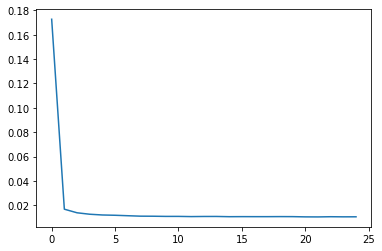

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]]).to(DEVICE)
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:].reshape(1, 1, -1), hidden)
  
#  print("output = {}".format(output[0]))
  
  predict_tensor = torch.cat((predict_tensor, output[-1:]), 0)
#  print("predict = {}".format(predict))

predict[:,0].shape = (100,)
predict[:,1].shape = (100,)


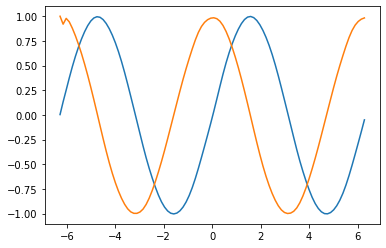

In [20]:
predict = predict_tensor.cpu().detach().numpy()

print("predict[:,0].shape = {}".format(predict[:,0].shape))
print("predict[:,1].shape = {}".format(predict[:,1].shape))

plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])